## Quaternion Models for Renewable Energy weather-based data generation and forecasting

This notebook is part of the code from the official implementation of the paper:

> Gianfranco Di Marco, Danilo Comminiello, Michele Scarpiniti, Aurelio Uncini: "*Quaternion Gated Recurrent Units for Renewable Energy: Improving Power Forecasting*", IEEE:10.1109/ICECS58634.2023.10382909, 2023

In addition, there is code for power data generation and forecasting with generative models, i.e. Variational Autoencoders and Generative Adversarial Networks.

\
**- Quaternion Generative Models -**

Quaternion Generative Models are a pretty new category of Generative Adversarial Networks, that generate data like the classic approaches but preserve a lot of memory and are more robusts with respect to the choice of parameters. Furthermore, they are amazing because they exploit the structure of the Quaternion in order to maintain the original intrinsic relations of the original data, without determining an increase of memory consumption.

> Eleonora Grassucci, Danilo Comminiello and Aurelio Uncini: "*A Quaternion-Valued Variational Autoencoder*", arXiv:2010.11647, 2020.

> Eleonora Grassucci, Edoardo Cicero and Danilo Comminiello: "*Quaternion Generative Adversarial Networks*", arXiv:2104.09630, 2021.

**- Energy data generation -**

In the field of Renewable Energy it's very important to balance accurately the power distributed to the users, because these sources are handled in a less efficient way with respect to the classic ones, and they are not always available (think about the solar energy during the night or cloudy days); indeed, it's very important to have the best data possible in order to make forecastings about energy production and/or consumption in a process that is named "*Intelligent Demand/Response*". Anyway, there is a lack of data regarding this field, so it's of critical importance to produce quality synthetic data that can be used to simulate plants (or loads) and allow experiments to improve forecasting.

**- Smart Grids -**

Smart Grids are very challenging about the forecasts, because here there is a bilateral exchange of energy between users and power plants, and all is managed through embedded systems and IoT, leading the energy distribution process to another level. Simulation of these infrastructures with quality data and a lot of experiments can ensure the stability of a real grid and a better energy management.

**- GEFCom 2014 Dataset -**

Available at. https://www.sciencedirect.com/science/article/pii/S0169207016000133#s000140. The *Global Energy Forecasting Competition* (GEFCom) is an important challenge in which various renewable energy-related tasks must have been achieved by the participants: 

*   Solar Power forecasting
*   Wind Power forecasting
*   Load Power forecasting
*   Energy Price forecasting

The dataset involved in this challenge contains power generated by different plants and weather informations, with samples collected hourly for several years. We can exploit all this data to generate energy scenarios and simulate real plants


> Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli, Rob J. Hyndman: "*Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond*", International Journal of Forecasting, Volume 32, Issue 3, 2016.

## Requirements

**Environment**

In [1]:
""" Necessary because: 
    - Google Colab does not support latest Python versions
    - Some libraries can be different between local and Colab
    - Resource usage is different between local and Colab
"""
try:
    import google.colab
    from google.colab import drive
    ENVIRONMENT = "colab"
except:
    ENVIRONMENT = "local"

**Libraries**

In [2]:
# Generic
import os
import sys
import json
import time
import shutil
import pickle
import pandas as pd
from pprint import pprint
from dill.source import getsource

# Learning
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.utilities.model_summary import ModelSummary

# Local Module files
sys.path.append(os.path.normpath(
    os.path.join(os.getcwd(), "..")))
from config import settings
from qnets_power.dataset import *
from qnets_power.models.vae import *
from qnets_power.models.gan import *
from qnets_power.models.rnn import *
from qnets_power.plot_tools import *
from qnets_power.metrics import EnergyMetricsComputer
from qnets_power.registry import MODEL_REGISTRY

## Configuration

In [3]:
# General parameters
MODEL = ["qvae", "rqvae", "qgan", "qrnn"]#[settings["model"]["default"]]
ENERGY_SOURCE = settings["data"]["source"]
QUATERNION_MODE = settings["data"]["quaternion_mode"]
NUM_EPOCHS = settings["train"]["epochs"]
NUM_SCENARIOS = settings["data"]["num_scenarios"]
DES_METRIC = settings["test"]["des_metric"]
SPEED_CHECK = True

# Training Parameters
BATCH_SIZE = settings["train"]["batch_size"]
PLOT_PERIOD = settings["train"]["plot_period"]
PRINT_PERIOD = settings["train"]["print_period"]
CHECKPOINT_PERIOD = settings["train"]["checkpoint"]["period"]
CHECKPOINT_METHOD = settings["train"]["checkpoint"]["method"]

**Fast setting (Google Colab only)**

Useful parameters to set before a Google Colab testing session (default values have been already assigned before):

>*   ```ENERGY_SOURCE```: the energy source (or load) to be analyzed
>*   ```QUATERNION_MODE```: the conversion mode to quaternion data
>*   ```NUM_EPOCHS```: how many epochs for which to train the model
>*   ```NUM_SCENARIOS```: number of scenarios to generate with the model for the given dataset
>*   ```BATCH_SIZE```: number of dataset elements in a batch
>*   ```PLOT_PERIOD```: period of iterations to plot train data
>*   ```PRINT_PERIOD```: period of iterations to print training trend
>*   ```CHECKPOINT_PERIOD```: period of iterations to save model checkpoints
>*   ```CHECKPOINT_METHOD```: method to model checkpoints

In [4]:
if ENVIRONMENT == "colab":

    #@markdown - General Parameters
    ENERGY_SOURCE = "solar"     #@param ["wind", "solar"] {type:"string"}
    QUATERNION_MODE = "reshape" #@param ["reshape", "organize", "timestack"] {type:"string"}
    NUM_EPOCHS = 400            #@param {type:"slider", min:1, max:400, step:1}
    NUM_SCENARIOS = 100         #@param {type:"slider", min:1, max:100, step:1}

    #@markdown - Training Parameters
    BATCH_SIZE = 256            #@param {type:"slider", min:8, max:512, step:8}
    PLOT_PERIOD = 1             #@param {type:"slider", min:1, max:10000, step:1}
    PRINT_PERIOD = 1            #@param {type:"slider", min:1, max:10000, step:1}
    CHECKPOINT_PERIOD = 1       #@param {type:"slider", min:1, max:10000, step:1}
    CHECKPOINT_METHOD = "best"  #@param ["best", "last"] {type:"string"}

## Initialization

**Parameters adjustment**

In [5]:
# Quaternion mode selection
q_models = []
quaternion_mode = None
for model_name in MODEL:
    if ENERGY_SOURCE == "solar":
        if "vae" in model_name:
            settings["model"][model_name]["latent_space"] = 40
    if "q" in model_name:
        q_models.append(model_name)
        quaternion_mode = QUATERNION_MODE
if len(q_models) > 0 and len(q_models) != len(MODEL):
    raise ValueError("You cannot mix quaternion and normal models")
quaternion_mode_str = "" if quaternion_mode is None else quaternion_mode

### Device initialization

In [6]:
device_time = time.time()
print("\n- Device init ...", end=" ", flush=True)
device = torch.device(
    "cuda:0" if torch.cuda.is_available() else "cpu")
n_gpus = min(1, torch.cuda.device_count())
if device.type == "cuda":
    accelerator = "gpu"
    devices = n_gpus
elif device.type == "cpu":
    accelerator = "cpu"
    devices = 1
torch.set_float32_matmul_precision(
    settings["train"]["matmul_precision"])
print(f"Done! ({round(time.time() - device_time, 1)} s)")


- Device init ... Done! (0.1 s)


### Dataset initialization

In [7]:
data_time = time.time()
print("\n- Dataset and Data Module init ...")
pl.seed_everything(settings["data"]["pl_seed"])
pd.options.mode.chained_assignment = None
if ENERGY_SOURCE == "solar":
    dataset = Solar2014Dataset(split="complete")
elif ENERGY_SOURCE == "wind":
    dataset = Wind2014Dataset(split="complete")
else:
    raise ValueError("Wind and solar are the only available sources")
pow_hours = 24 - np.array(dataset.zones_zero_pow).shape[-1]
train_dataset, val_dataset, test_dataset = dataset.split_all()
datamodule = GEFCom2014DataModule(
    train_dataset, val_dataset, test_dataset,
    batch_size=BATCH_SIZE, quaternion_mode=quaternion_mode)
print(f"Done! ({round(time.time() - data_time, 1)} s)")
train_dataset.general_info()
val_dataset.general_info()
test_dataset.general_info()

Seed set to 42



- Dataset and Data Module init ...


/mnt/c/Users/Gianf/Desktop/Progetti/Tesi/Code/QNETs_Power_Forecasting/src/qnets_power/dataset.py:296: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.dataframe = self.dataframe.groupby(["ZONEID"]).apply(


Done! (0.5 s)
___________ General Dataset Informations ___________

- Dataset name: GEFCom_2014 solar [train]
- Number of samples: 51840
- Data sample:
    ZONEID       TIMESTAMP     VAR78  VAR79      VAR134      VAR157    VAR164  \
0     1.0  20120402 01:00  0.001480    0.0  94730.3750   95.559967  0.039764   
1     1.0  20120402 02:00  0.005981    0.0  94721.5625   99.391953  0.386597   
2     1.0  20120402 03:00  0.020294    0.0  94707.7500   99.679733  0.937317   
3     1.0  20120402 04:00  0.043617    0.0  94699.6875  100.207092  0.970123   
4     1.0  20120402 05:00  0.047783    0.0  94733.3125   99.531464  0.893005   

     VAR165    VAR166      VAR167  VAR169     VAR175  VAR178        VAR228  \
0  0.622430  0.318149  284.133057     0.0  1077424.0     0.0  0.000000e+00   
1 -0.404500  1.343286  282.870117     0.0  1091232.0     0.0  1.325000e-10   
2 -0.493649  1.279655  282.885498     0.0  1147024.0     0.0  0.000000e+00   
3 -0.298454  1.204877  283.157227     0.0  1192656.0  

### Model initialization

In [8]:
models = {}
for model_name in MODEL:
    model_time = time.time()
    print(f"\n{model_name.upper()} Model init ...", end=" ", flush=True)

    # Initialize model-specific paths
    model_checkpoints_path = os.path.join(
        settings["path"]["checkpoints"], model_name,
        ENERGY_SOURCE, quaternion_mode_str)
    os.makedirs(model_checkpoints_path, exist_ok=True)
    
    # Initialize model class and args
    in_cond = datamodule.get_inference_size(phase="train")
    model_class = MODEL_REGISTRY[model_name]
    model_config = settings["model"][model_name]
    model_kwargs = model_class.get_default_kwargs(
        pow_hours, in_cond, device)
    model_kwargs.update(model_config)
    model_kwargs["name"] = model_name
    model = model_class(**model_kwargs).to(device)
    models[model_name] = {
        "model": model,
        "kwargs": model_kwargs,
        "paths": {"checkpoints": model_checkpoints_path}}

    # Show model info
    print(f"Done! ({round(time.time() - model_time, 1)} s)")
    print("Model Parameters =", sum(
        p.numel() for p in model.parameters() if p.requires_grad))
    print("Model Architecture:\n", model)


QVAE Model init ... Done! (0.6 s)
Model Parameters = 192936
Model Architecture:
 QVAE(
  (loss): QVAELoss()
  (encoder): Sequential(
    (0): QuaternionLinear(in_features=17, out_features=50, bias=True, init_criterion=he, weight_init=quaternion, seed=1126)
    (1): ReLU()
    (2): QuaternionLinear(in_features=50, out_features=100, bias=True, init_criterion=he, weight_init=quaternion, seed=1111)
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): QuaternionLinear(in_features=400, out_features=80, bias=True, init_criterion=he, weight_init=quaternion, seed=296)
  )
  (decoder): Sequential(
    (0): QuaternionLinear(in_features=92, out_features=50, bias=True, init_criterion=he, weight_init=quaternion, seed=225)
    (1): ReLU()
    (2): QuaternionLinear(in_features=50, out_features=100, bias=True, init_criterion=he, weight_init=quaternion, seed=10)
    (3): ReLU()
    (4): QuaternionLinear(in_features=100, out_features=4, bias=True, init_criterion=he, weight_init=quaternion,

## Training

### Training setup

In [9]:
train_setup_time = time.time()
print(f"\nTraining setup ...", end=" ", flush=True)
datamodule.setup(stage="fit")
n_batches = int(len(datamodule.train_dataloader().dataset) // BATCH_SIZE)
print(f"Done! ({round(time.time() - train_setup_time, 1)} s)")


Training setup ... Done! (0.2 s)


### Training loop

In [10]:
for model_name, model_dict in models.items():
    train_time = time.time()
    print(f"\n----------- {model_name.upper()} training -----------")

    ## Checkpoint callback specification
    if model_name in ["gan", "qgan"]:
        #checkpoint_monitor = "val_dis_loss"
        checkpoint_monitor = None
        save_top_k = 1
    else:
        checkpoint_monitor = \
            settings["train"]["checkpoint"]["monitor"]
        save_top_k = settings["train"]["top_k_save"]
    checkpoint_callback = ModelCheckpoint(
        dirpath=model_dict["paths"]["checkpoints"], save_last=True,
        monitor=checkpoint_monitor, save_top_k=save_top_k,
        every_n_epochs=settings["train"]["checkpoint"]["period"])

    ## Trainer initialization
    trainer = pl.Trainer(
        accelerator=accelerator, devices=devices,
        callbacks=[checkpoint_callback],
        max_epochs=NUM_EPOCHS, log_every_n_steps=n_batches/2,
        default_root_dir=settings["path"]["root"])

    ## Model training
    model = model_dict["model"]
    trainer.fit(model, datamodule)

    # Additional checkpoint informations
    with open(os.path.join(
            model_dict["paths"]["checkpoints"],
                "checkpoints_info.pt"), "wb") as f:
        pickle.dump(checkpoint_callback.best_k_models, 
                    f, protocol=pickle.HIGHEST_PROTOCOL)
    best_path = os.path.join(
        model_dict["paths"]["checkpoints"], "best")
    os.makedirs(best_path, exist_ok=True)
    shutil.copy(checkpoint_callback.best_model_path, best_path)
    print(f"\n{model_name.upper()} training completed in " + \
          f"{round(time.time() - train_time, 1)} s.\n")


----------- QVAE training -----------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | loss    | QVAELoss   | 0      | train
1 | encoder | Sequential | 152 K  | train
2 | decoder | Sequential | 40.6 K | train
-----------------------------------------------
192 K     Trainable params
0         Non-trainable params
192 K     Total params
0.772     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 33/33 [00:00<00:00, 48.41it/s, v_num=35]        

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 33/33 [00:01<00:00, 31.57it/s, v_num=35]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



QVAE training completed in 104.5 s.


----------- RQVAE training -----------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | loss    | RQVAELoss  | 0      | train
1 | encoder | Sequential | 152 K  | train
2 | decoder | Sequential | 40.6 K | train
-----------------------------------------------
192 K     Trainable params
0         Non-trainable params
192 K     Total params
0.772     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 33/33 [00:00<00:00, 50.66it/s, v_num=36]        

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 33/33 [00:01<00:00, 24.21it/s, v_num=36]

RQVAE training completed in 121.6 s.


----------- QGAN training -----------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | loss          | QGANLoss   | 0      | train
1 | discriminator | Sequential | 28.2 K | train
2 | generator     | Sequential | 45.4 K | train
-----------------------------------------------------
73.6 K    Trainable params
0         Non-trainable params
73.6 K    Total params
0.294     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 33/33 [00:01<00:00, 29.77it/s, v_num=37, train_dis_loss=0.818, train_gen_loss=1.830, val_dis_loss=0.968, val_gen_loss=1.830, step=99.00]  

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 33/33 [00:01<00:00, 18.76it/s, v_num=37, train_dis_loss=0.818, train_gen_loss=1.830, val_dis_loss=0.968, val_gen_loss=1.830, step=99.00]

QGAN training completed in 155.7 s.


----------- QRNN training -----------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type     | Params | Mode 
------------------------------------------
0 | loss | QRNNLoss | 0      | train
1 | gru  | QGRU     | 160 K  | train
2 | fc   | Linear   | 3.2 K  | train
------------------------------------------
163 K     Trainable params
0         Non-trainable params
163 K     Total params
0.655     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 33/33 [00:02<00:00, 12.78it/s, v_num=38]        

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 33/33 [00:02<00:00, 11.13it/s, v_num=38]

QRNN training completed in 319.0 s.



## Testing

### Testing setup

In [11]:
test_setup_time = time.time()
print(f"\nTesting setup ...", end=" ", flush=True)
datamodule.setup(stage="test")
metrics_computer = EnergyMetricsComputer(["all"], device=device)
print(f"Done! ({round(time.time() - test_setup_time, 1)} s)")


Testing setup ... Done! (0.0 s)


### Testing loop


----------- QVAE testing -----------

- Model checkpoint loading [method=best] ... Done! (2.0 s)

- Speed check ... 

100%|██████████| 2160/2160 [00:04<00:00, 498.48it/s]


Done! (4.3 s)
solar_train total forecasting time = 4.33635950088501
solar_train mean forecasting time = 0.0020075738430023193
solar_train forecasts/s time = 498.11368258539557

- Scenarios generation ...


100%|██████████| 150/150 [00:00<00:00, 650.51it/s]


solar_test100 at day total generation time = 0.23305892944335938
solar_test100 at day mean generation time = 0.0015537261962890625
solar_testscenarios/s generation time = 6.4361404370243065
Done! (0.4 s)

- Scenarios loading ... Done! (0.3 s)

- Scenarios processing ... Done! (0.0 s)

- Metrics computation ... 
qvae metrics computation ...


100%|██████████| 99/99 [00:00<00:00, 7155.42it/s]


Done! (2.9 s)

Metrics results:
{'error metrics': {'mae': {'best': 0.033, 'best_idx': 87, 'value': 0.034},
                   'mape': {'best': 17.0903, 'best_idx': 52, 'value': 25.4371},
                   'mbe': {'best': -0.0066, 'best_idx': 52, 'value': -0.0052},
                   'rmse': {'best': 0.0691, 'best_idx': 5, 'value': 0.0705}},
 'extra metrics': {'es': {'best': 4.3149, 'best_idx': 97, 'value': 24.8739},
                   'qs': {'best': 0.6417, 'best_idx': 0, 'value': 1.3696}},
 'statistical metrics': {'cosi': {'best': 0.9782,
                                  'best_idx': 5,
                                  'value': 0.9773},
                         'crps': {'best': 0.0, 'best_idx': 0, 'value': 2.7149},
                         'pcorr': {'best': 0.9683,
                                   'best_idx': 5,
                                   'value': 0.9669}}}


100%|██████████| 100/100 [00:00<00:00, 3805.57it/s]


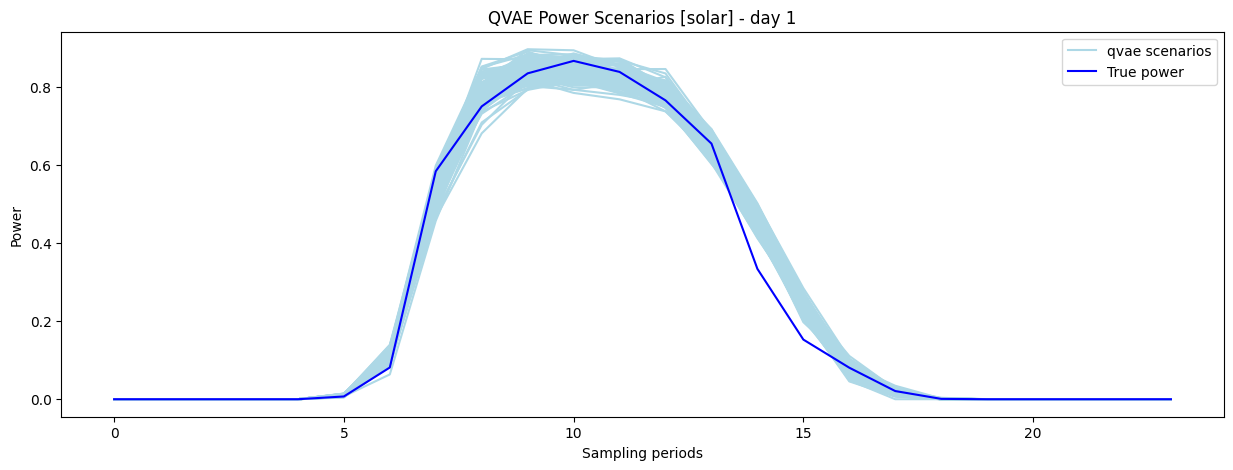

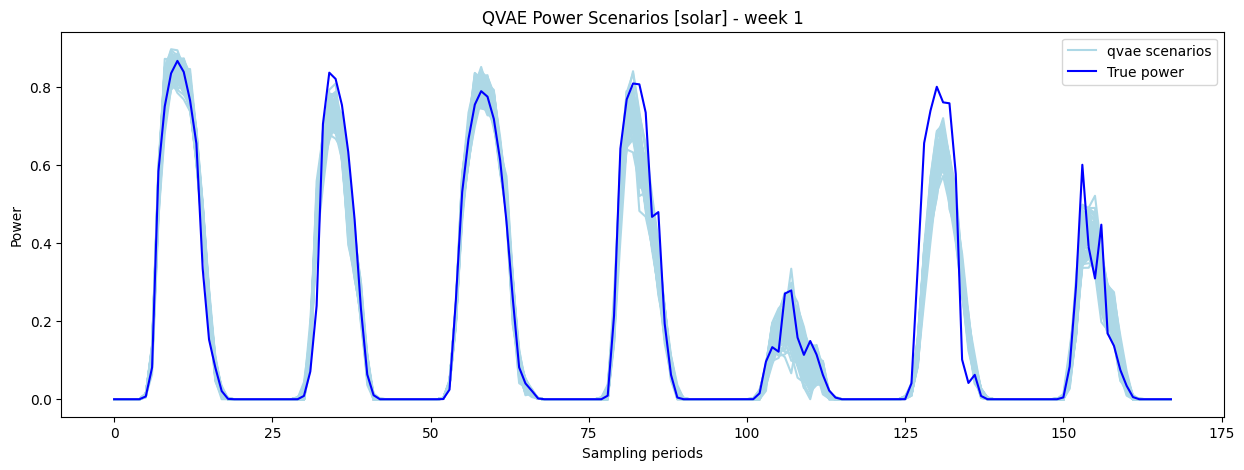

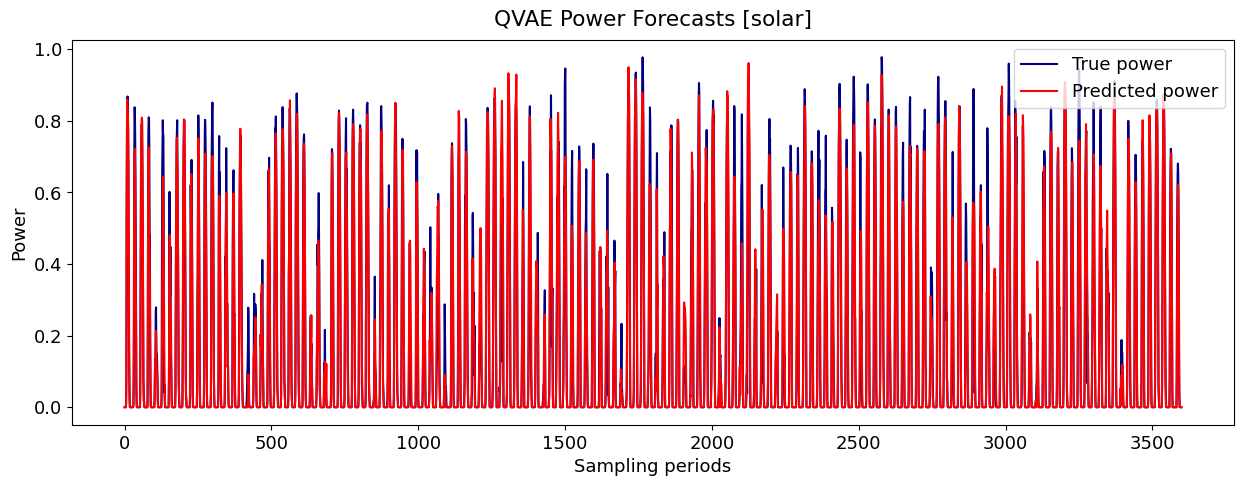

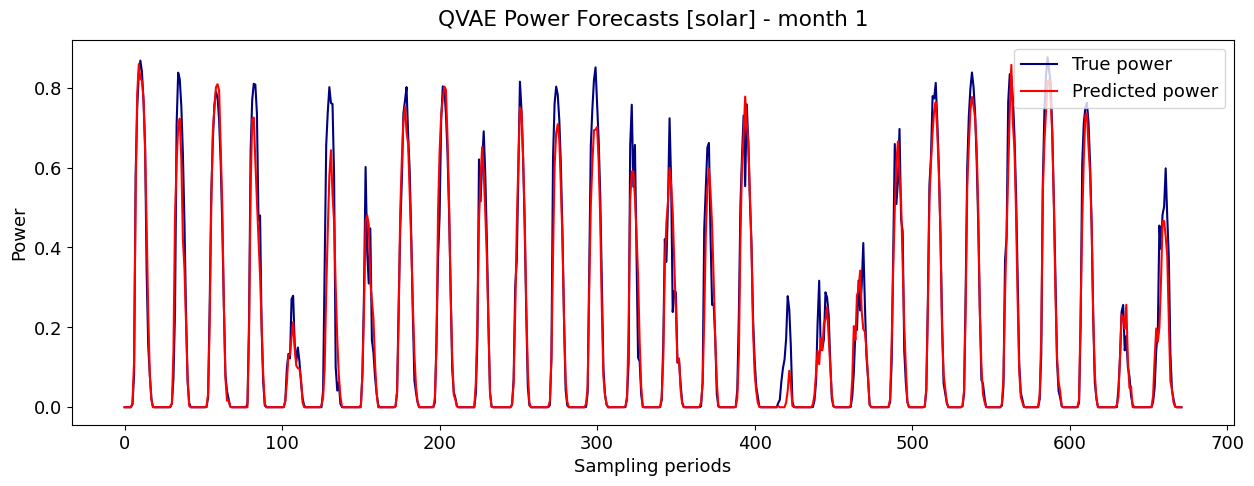

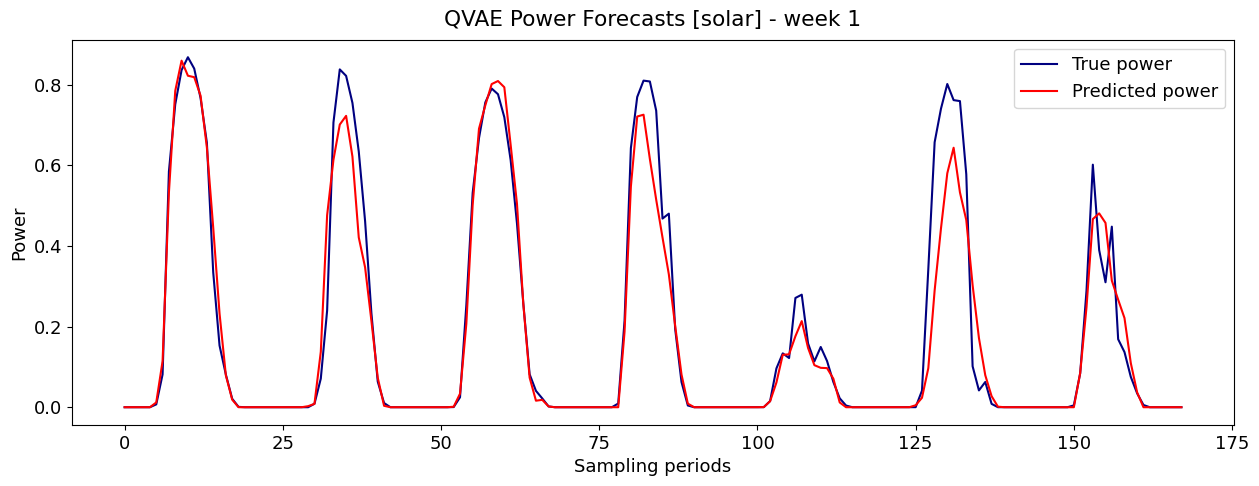


QVAE testing completed in 11.6 s.

----------- RQVAE testing -----------

- Model checkpoint loading [method=best] ... Done! (0.8 s)

- Speed check ... 

100%|██████████| 2160/2160 [00:04<00:00, 495.94it/s]


Done! (4.4 s)
solar_train total forecasting time = 4.3567914962768555
solar_train mean forecasting time = 0.0020170331001281737
solar_train forecasts/s time = 495.77768452905127

- Scenarios generation ...


100%|██████████| 150/150 [00:00<00:00, 610.34it/s]

solar_test100 at day total generation time = 0.24811792373657227
solar_test100 at day mean generation time = 0.0016541194915771485
solar_testscenarios/s generation time = 6.045512462020098
Done! (0.3 s)

- Scenarios loading ... 

Done! (0.2 s)

- Scenarios processing ... Done! (0.0 s)

- Metrics computation ... 
rqvae metrics computation ...


100%|██████████| 99/99 [00:00<00:00, 5236.73it/s]


Done! (2.8 s)

Metrics results:
{'error metrics': {'mae': {'best': 0.0304, 'best_idx': 10, 'value': 0.0316},
                   'mape': {'best': 24.5613, 'best_idx': 50, 'value': 34.655},
                   'mbe': {'best': -0.0015, 'best_idx': 39, 'value': 0.0004},
                   'rmse': {'best': 0.0658, 'best_idx': 10, 'value': 0.0684}},
 'extra metrics': {'es': {'best': 3.0355, 'best_idx': 131, 'value': 22.4469},
                   'qs': {'best': 0.5059, 'best_idx': 98, 'value': 1.2186}},
 'statistical metrics': {'cosi': {'best': 0.9801,
                                  'best_idx': 10,
                                  'value': 0.9784},
                         'crps': {'best': 0.0, 'best_idx': 0, 'value': 2.4142},
                         'pcorr': {'best': 0.971,
                                   'best_idx': 10,
                                   'value': 0.9686}}}


100%|██████████| 100/100 [00:00<00:00, 2649.29it/s]


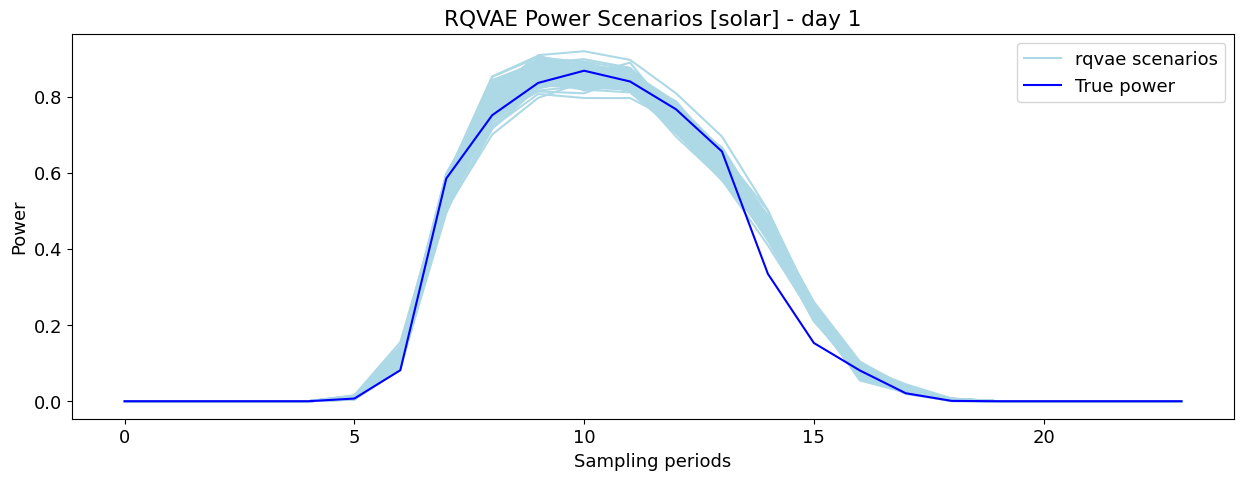

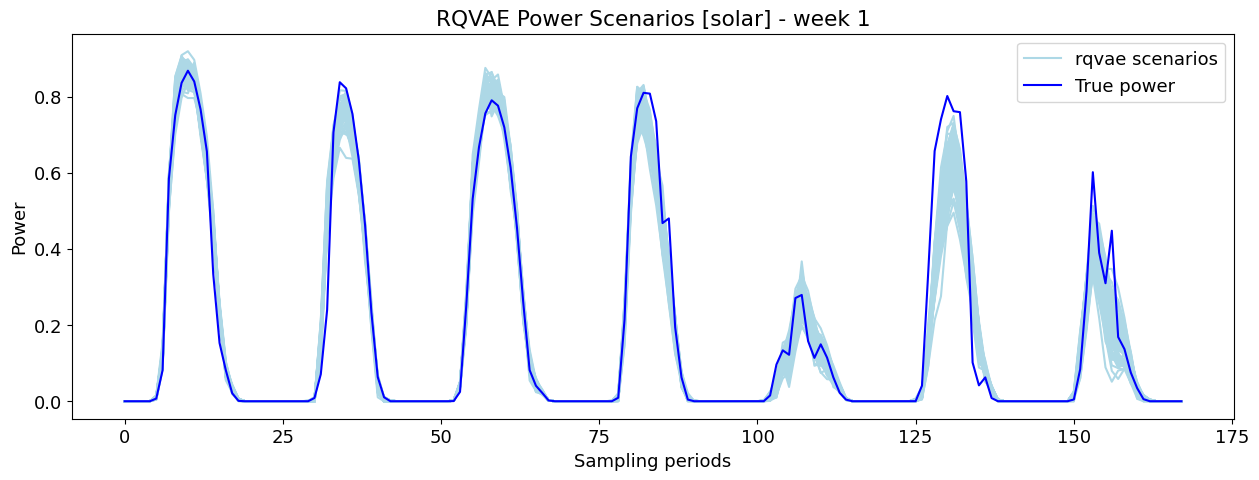

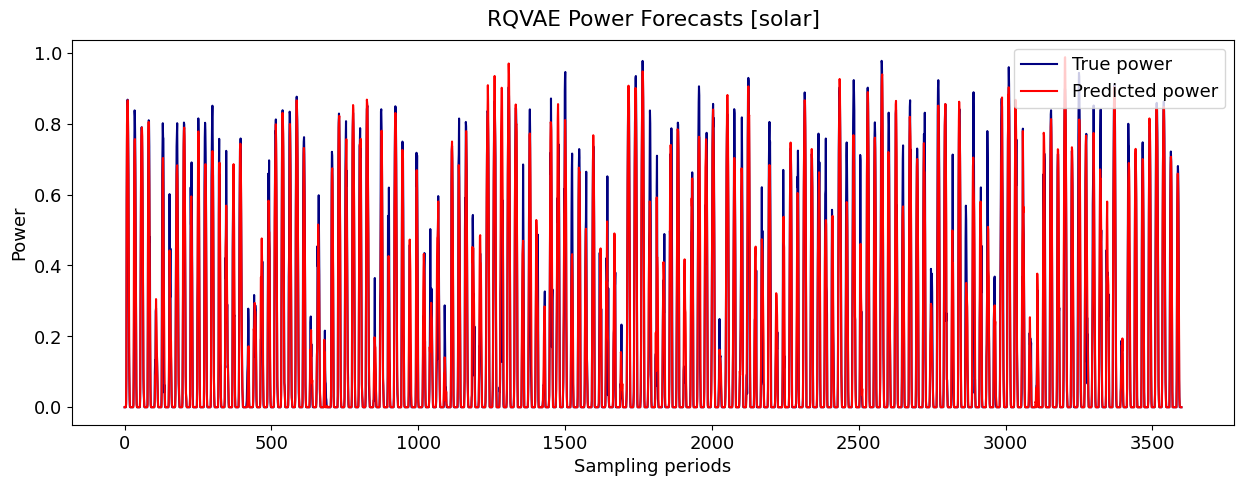

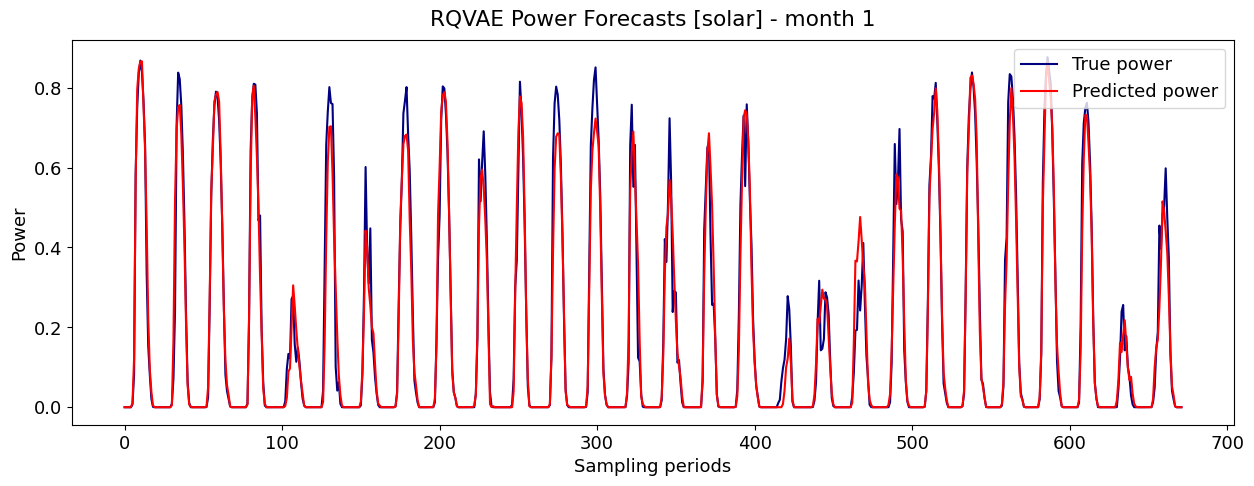

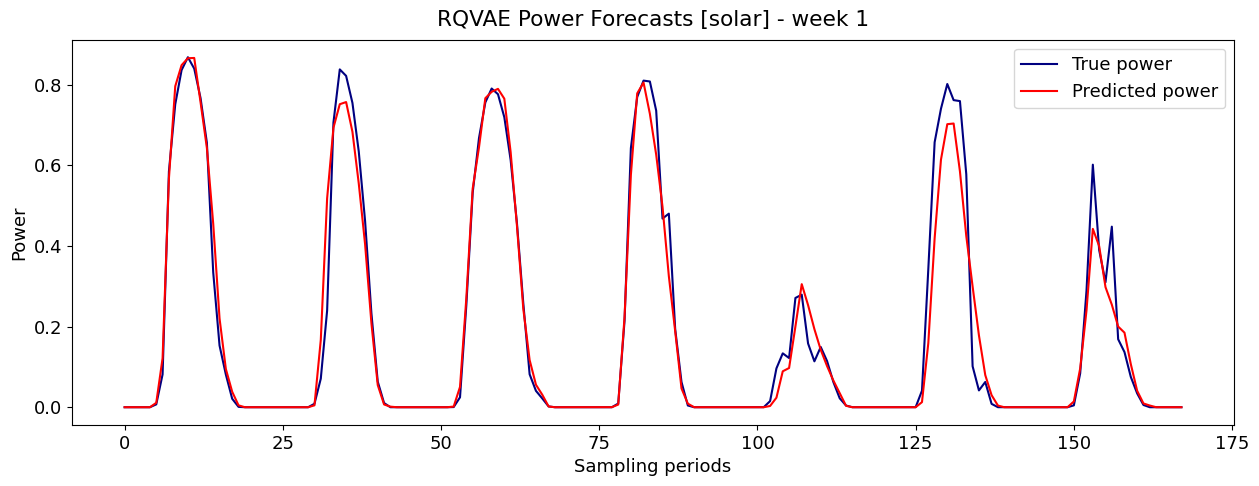


RQVAE testing completed in 9.5 s.

----------- QGAN testing -----------

- Model checkpoint loading [method=best] ... Done! (0.7 s)

- Speed check ... 

100%|██████████| 2160/2160 [00:05<00:00, 413.56it/s]


Done! (5.2 s)
solar_train total forecasting time = 5.224509000778198
solar_train mean forecasting time = 0.0024187541670269434
solar_train forecasts/s time = 413.4359802381937

- Scenarios generation ...


100%|██████████| 150/150 [00:00<00:00, 550.70it/s]


solar_test100 at day total generation time = 0.2744014263153076
solar_test100 at day mean generation time = 0.0018293428421020507
solar_testscenarios/s generation time = 5.466443888948262
Done! (0.3 s)

- Scenarios loading ... Done! (0.2 s)

- Scenarios processing ... Done! (0.0 s)

- Metrics computation ... 
qgan metrics computation ...


100%|██████████| 99/99 [00:00<00:00, 6236.93it/s]


Done! (2.8 s)

Metrics results:
{'error metrics': {'mae': {'best': 0.0536, 'best_idx': 99, 'value': 0.055},
                   'mape': {'best': 42.9155, 'best_idx': 69, 'value': 61.9858},
                   'mbe': {'best': -0.0101, 'best_idx': 3, 'value': -0.0057},
                   'rmse': {'best': 0.1057, 'best_idx': 26, 'value': 0.109}},
 'extra metrics': {'es': {'best': 7.8918, 'best_idx': 64, 'value': 35.4713},
                   'qs': {'best': 1.1293, 'best_idx': 0, 'value': 2.0934}},
 'statistical metrics': {'cosi': {'best': 0.9477,
                                  'best_idx': 26,
                                  'value': 0.9442},
                         'crps': {'best': 0.0, 'best_idx': 0, 'value': 4.1597},
                         'pcorr': {'best': 0.9236,
                                   'best_idx': 26,
                                   'value': 0.9186}}}


100%|██████████| 100/100 [00:00<00:00, 3780.63it/s]


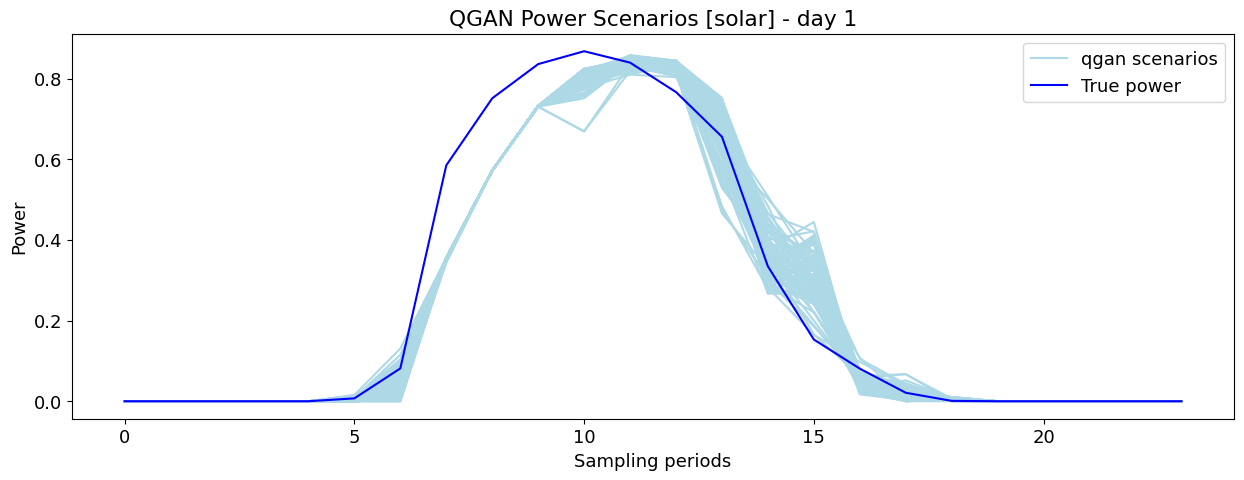

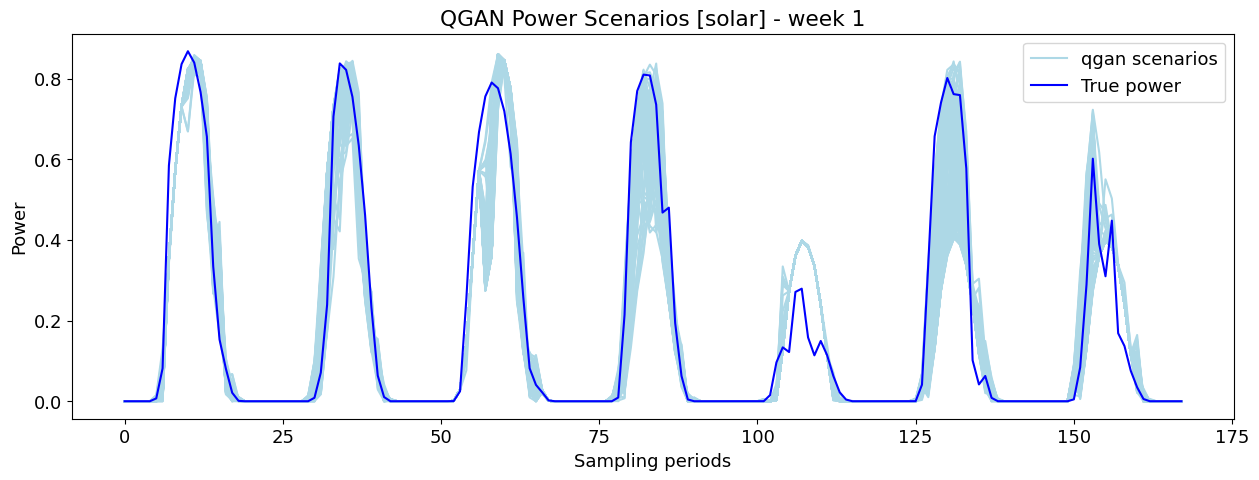

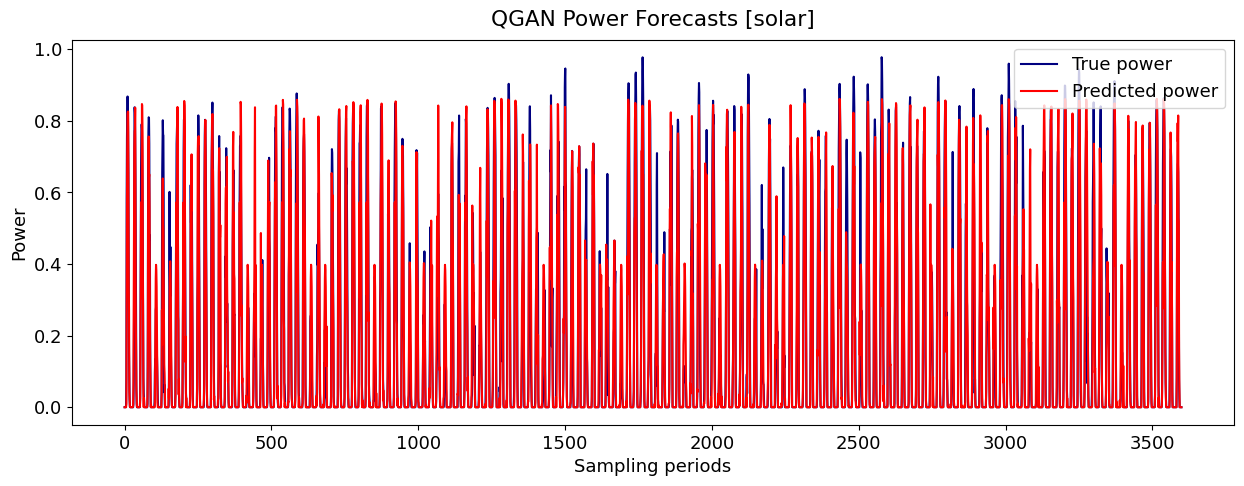

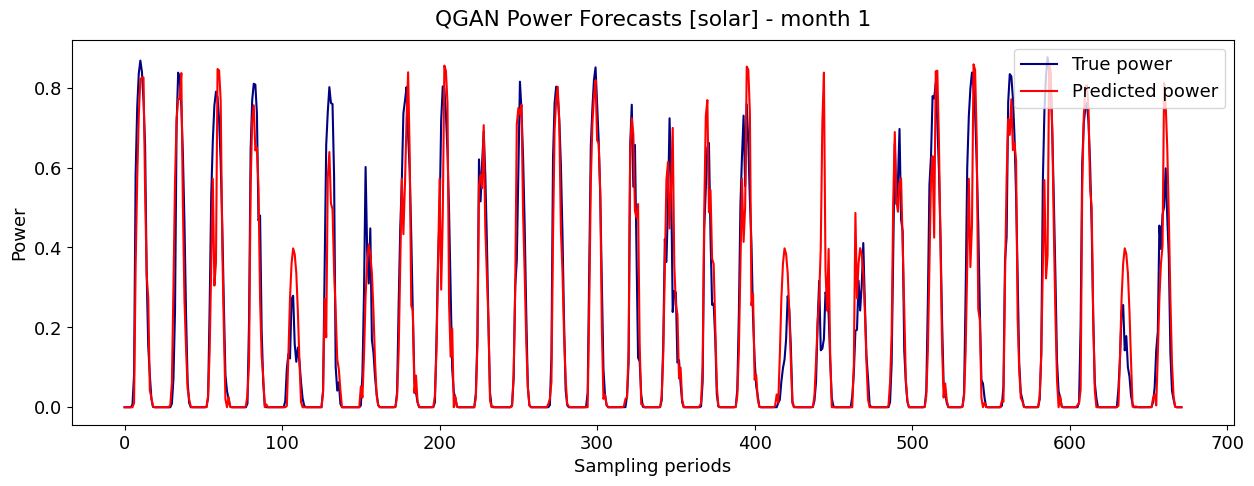

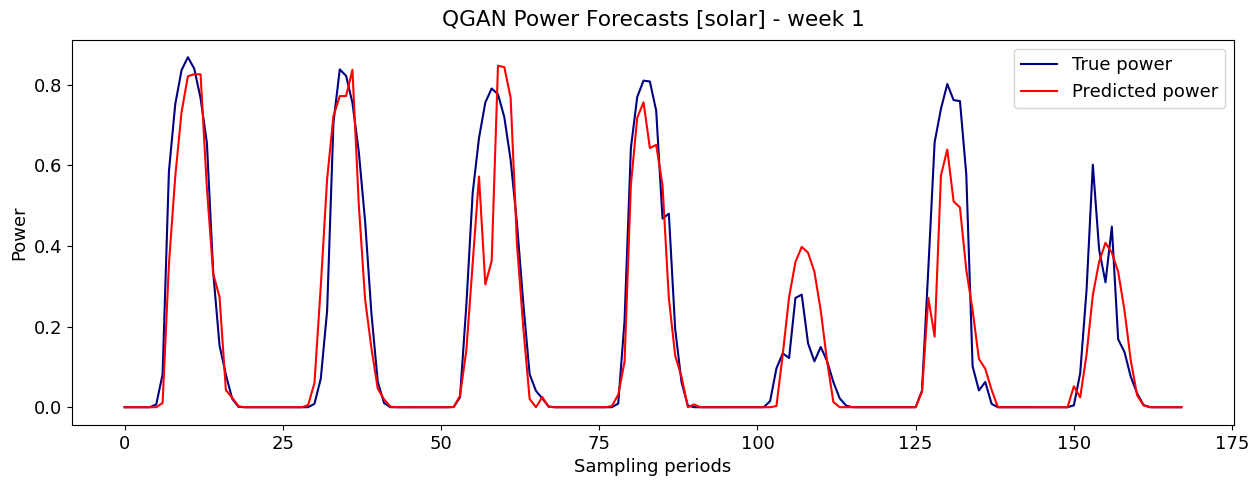


QGAN testing completed in 10.8 s.

----------- QRNN testing -----------

- Model checkpoint loading [method=best] ... Done! (0.8 s)

- Speed check ... 

100%|██████████| 2160/2160 [00:31<00:00, 68.31it/s] 


Done! (31.6 s)
solar_train total forecasting time = 31.62126588821411
solar_train mean forecasting time = 0.014639474948247274
solar_train forecasts/s time = 68.30846075662885

- Scenarios generation ...


100%|██████████| 150/150 [00:02<00:00, 61.13it/s]

solar_test100 at day total generation time = 2.45605731010437
solar_test100 at day mean generation time = 0.0163737154006958
solar_testscenarios/s generation time = 0.6107349343310957
Done! (2.5 s)

- Scenarios loading ... 

Done! (0.1 s)

- Scenarios processing ... Done! (0.0 s)

- Metrics computation ... 
qrnn metrics computation ...


100%|██████████| 99/99 [00:00<00:00, 7295.98it/s]


Done! (0.1 s)

Metrics results:
{'error metrics': {'mae': {'best': 0.0304, 'best_idx': 0, 'value': 0.0304},
                   'mape': {'best': 8.9439, 'best_idx': 0, 'value': 8.9439},
                   'mbe': {'best': 0.0025, 'best_idx': 0, 'value': 0.0025},
                   'rmse': {'best': 0.0712, 'best_idx': 0, 'value': 0.0712}},
 'extra metrics': {'es': {'best': 4.0433, 'best_idx': 143, 'value': 28.706},
                   'qs': {'best': 1.3994, 'best_idx': 98, 'value': 1.5223}},
 'statistical metrics': {'cosi': {'best': 0.9768,
                                  'best_idx': 0,
                                  'value': 0.9768},
                         'crps': {'best': 0.0, 'best_idx': 0, 'value': 3.0446},
                         'pcorr': {'best': 0.9662,
                                   'best_idx': 0,
                                   'value': 0.9662}}}


100%|██████████| 1/1 [00:00<00:00, 1766.02it/s]


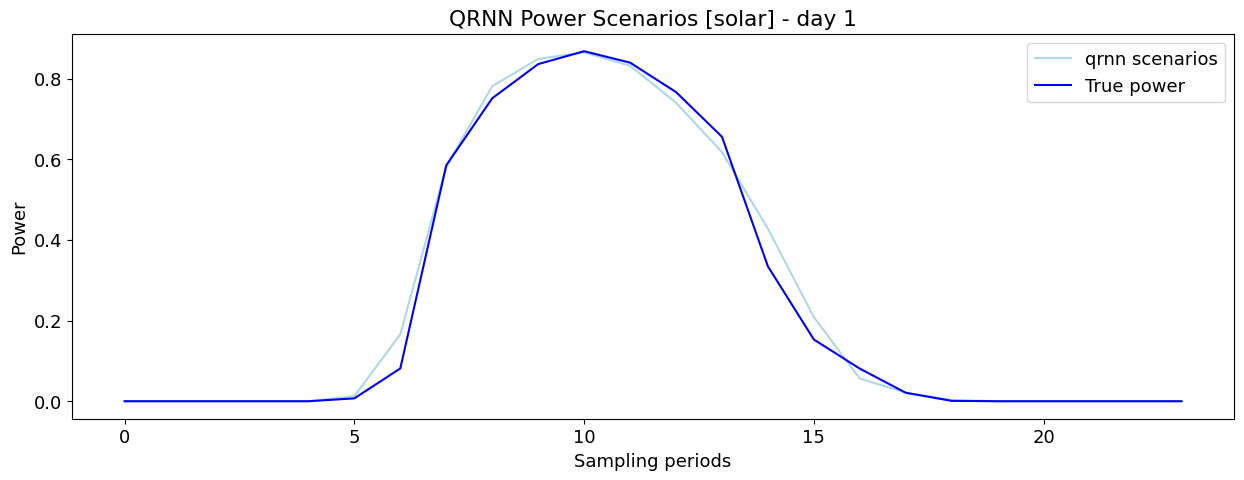

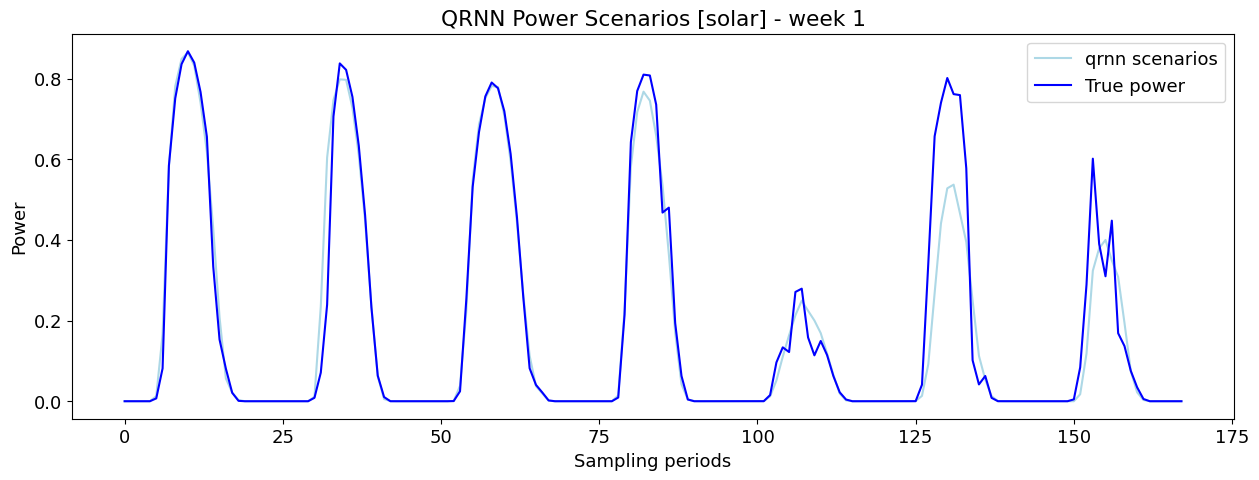

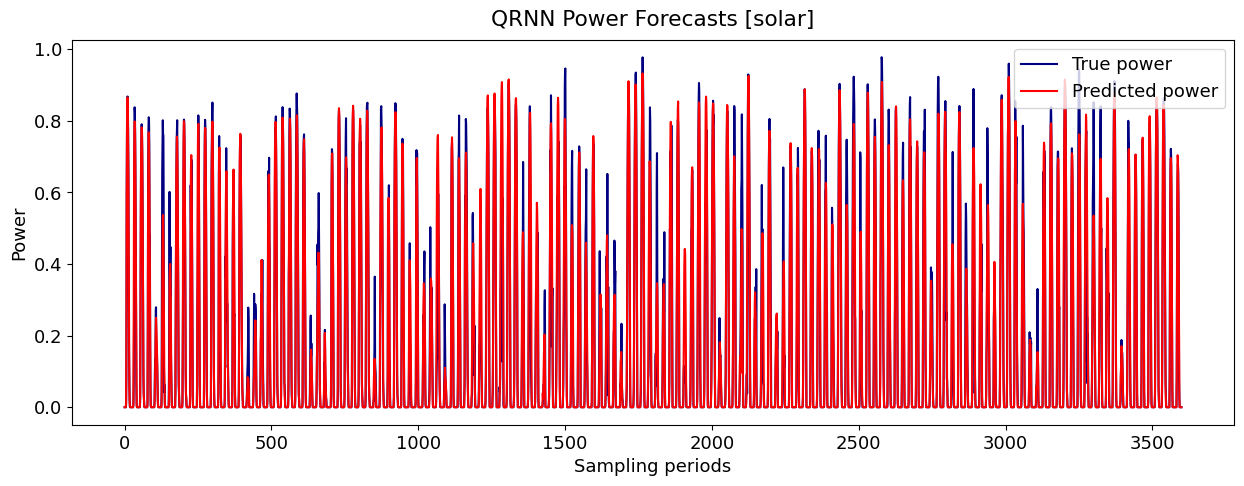

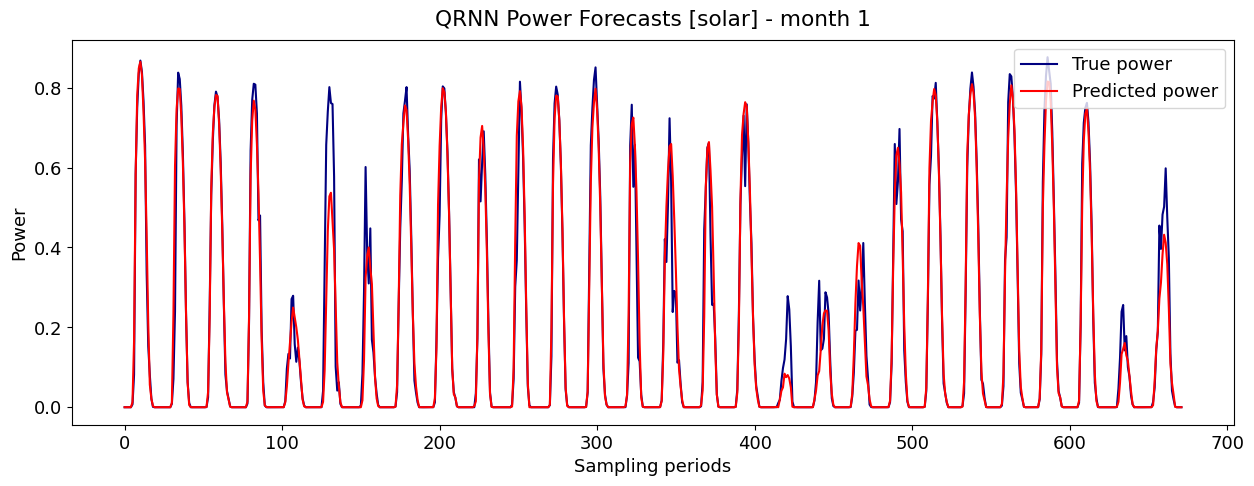

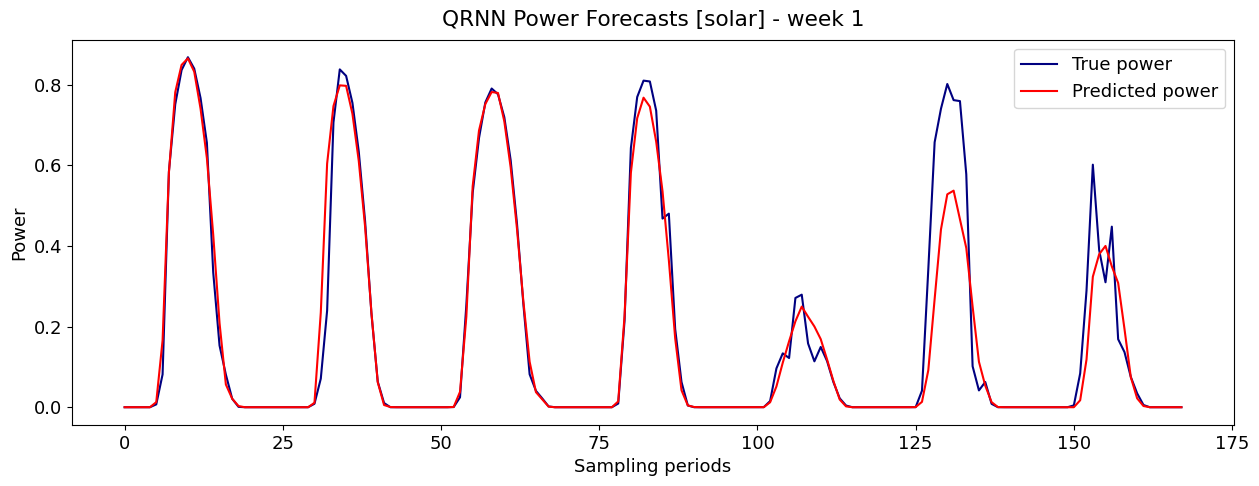


QRNN testing completed in 36.5 s.


In [12]:
for model_name, model_dict in models.items():
    test_time = time.time()
    print(f"\n----------- {model_name.upper()} testing -----------")

    # Model paths initialization
    model_scenarios_path = os.path.join(
        settings["path"]["results"], model_name,
        ENERGY_SOURCE, quaternion_mode_str, "scenarios")
    model_metrics_path = os.path.join(
        settings["path"]["results"], model_name,
        ENERGY_SOURCE, quaternion_mode_str, "metrics")
    model_plots_path = os.path.join(
        settings["path"]["results"], model_name,
        ENERGY_SOURCE, quaternion_mode_str, "plots")
    model_speed_path = os.path.join(
        settings["path"]["results"], model_name,
        ENERGY_SOURCE, quaternion_mode_str, "speed")
    os.makedirs(model_scenarios_path, exist_ok=True)
    os.makedirs(model_metrics_path, exist_ok=True)
    os.makedirs(model_plots_path, exist_ok=True)
    os.makedirs(model_speed_path, exist_ok=True)
    model_dict["paths"].update({
        "scenarios": model_scenarios_path,
        "metrics": model_metrics_path,
        "plots": model_plots_path,
        "speed": model_speed_path})

    # Model loading from checkpoints
    checkload_time = time.time()
    checkpoint_method = CHECKPOINT_METHOD
    print(f"\n- Model checkpoint loading " + \
          f"[method={checkpoint_method}] ...", end=" ", flush=True)
    if checkpoint_method == "best":
        best_path = os.path.join(
            model_dict["paths"]["checkpoints"], "best")
        checkpoint_filepath = os.path.join(
            best_path, os.listdir(best_path)[0])
    elif checkpoint_method == "last":
        with open(os.path.join(
                model_dict["paths"]["checkpoints"],
                "checkpoints_info.pt"), "rb") as f:
            checkpoints_info = pickle.load(f)
        checkpoint_filepath = list(checkpoints_info.keys())[-1]
    else:
        raise ValueError(
            f"Checkpoint method {checkpoint_method} not supported")
    # NOTE: this is needed only to know the last epoch
    checkpoint = torch.load(checkpoint_filepath)
    model_class = MODEL_REGISTRY[model_name]
    model = model_class.load_from_checkpoint(
            checkpoint_filepath, map_location=None, hparams_file=None,
            strict=True, **model_dict["kwargs"]).to(device)
    print(f"Done! ({round(time.time() - checkload_time, 1)} s)")

    # Forward speed checking
    if SPEED_CHECK:
        speed_time = time.time()
        print(f"\n- Speed check ...", end=" ", flush=True)
        forecast_list = []
        try:
            data_split = datamodule.gefcom_train
        except AttributeError as ae:
            datamodule.setup(stage="fit")
            data_split = datamodule.gefcom_train
        days = list(range(len(data_split)))
        start_forward = time.time()
        for d in tqdm(days):
            with torch.no_grad():
                vars, power = data_split[d]
                vars = vars.unsqueeze(0).to(device)
                if model_name not in ["gan", "qgan"]:
                    if model_name not in ["rnn", "qrnn"]:
                        power = power.unsqueeze(0).to(device)
                        fcasts = model(vars, power)
                    else:
                        fcasts = model(vars)
                else:
                    noise = torch.randn(
                        vars.shape[0], model.latent_space).to(device)
                    fcasts_gen = model(vars, noise, net="gen")
                    fcasts_dis = model(
                        vars, fcasts_gen.unsqueeze(0), net="dis")
                    fcasts = [fcasts_gen, fcasts_dis]
            forecast_list.append(fcasts)
        total_forward = time.time() - start_forward
        forecast_day_time = total_forward / len(forecast_list)
        forecasts_per_s = 1 / forecast_day_time
        print(f"Done! ({round(time.time() - speed_time, 1)} s)")
        print(f"{dataset.source}_" +
                f"train total forecasting time = {total_forward}")
        print(f"{dataset.source}_" +
                f"train mean forecasting time = {forecast_day_time}")
        print(f"{dataset.source}_" +
                f"train forecasts/s time = {forecasts_per_s}")

    # Generate scenarios if not already done
    num_scenarios = \
        NUM_SCENARIOS if model_name not in ["rnn", "qrnn"] else 1
    scenarios_name = f"scenarios_{dataset.source}_" + \
        f"{model_name}_{num_scenarios}_{'test'}.tar"
    if (trainer is not None or \
            scenarios_name not in os.listdir(
                model_dict["paths"]["scenarios"])):
        scenarios_time = time.time()
        print(f"\n- Scenarios generation ...")
        test_scenarios, speed = datamodule.generate_scenarios(
            model, "test", num_scenarios, save=True,
            save_path=model_dict["paths"]["scenarios"])
        print(f"Done! ({round(time.time() - scenarios_time, 1)} s)")
        ## Save model generation/inference speed info
        speed_filename = os.path.join(
            model_dict["paths"]["speed"], "speed.json")
        with open(speed_filename, "w") as f:
            json.dump(speed, f, indent=2)

    # Load already generated scenarios
    load_scenarios_time = time.time()
    print(f"\n- Scenarios loading ...", end=" ", flush=True)
    test_scenarios = datamodule.load_scenarios(
        model, model_dict["paths"]["scenarios"],
        num_scenarios=num_scenarios, split="test")                    
    print(f"Done! ({round(time.time() - load_scenarios_time, 1)} s)")            

    # Scenarios reshaping
    prep_scenarios_time = time.time()
    print(f"\n- Scenarios processing ...", end=" ", flush=True)
    test_scenarios_reshaped = test_scenarios.reshape(
        len(test_scenarios) // num_scenarios, num_scenarios, 24)
    test_scenarios_reshaped = test_scenarios_reshaped.permute(1, 0, 2)
    test_scenarios_reshaped = \
        test_scenarios_reshaped.reshape(num_scenarios, -1)
    true_scenario = torch.from_numpy(
        test_dataset.dataframe["POWER"].values)
    print(f"Done! ({round(time.time() - prep_scenarios_time, 1)} s)")

    # Computing metrics
    metrics_time = time.time()
    print(f"\n- Metrics computation ...", end=" ", flush=True)
    print(f"\n{model_name} metrics computation ...")
    metric_results = metrics_computer(
        test_scenarios_reshaped, true_scenario)
    print(f"Done! ({round(time.time() - metrics_time, 1)} s)")
    print("\nMetrics results:")
    pprint(metric_results)
    metrics_filename = os.path.join(
        model_dict["paths"]["metrics"], "metrics.json")
    with open(metrics_filename, "w") as f:
        json.dump(metric_results, f, indent=2)

    # Best scenario selection
    met_sel = DES_METRIC
    energy_metrics = EnergyMetricsComputer.energy_metrics
    if met_sel in energy_metrics["error metrics"]:
        metric_type = "error metrics"
    elif met_sel in energy_metrics["statistical metrics"]:
        metric_type = "statistical metrics"
    elif met_sel in energy_metrics["extra metrics"]:
        metric_type = "extra metrics"
    best_idx = metric_results[metric_type][met_sel]["best_idx"]
    best_scenario = test_scenarios_reshaped[best_idx]

    # Scenarios visualization
    ## 1 - first day scenarios
    plot_power_scenarios(
        test_scenarios_reshaped, true_scenario, span=[0, 24],
        model=model_name, source=ENERGY_SOURCE,
        save=True, save_path=model_dict["paths"]["plots"])
    ## 2 - first week scenarios
    plot_power_scenarios(
        test_scenarios_reshaped, true_scenario, span=[0, 24*7],
        model=model_name, source=ENERGY_SOURCE,
        save=True, save_path=model_dict["paths"]["plots"])

    # True vs Pred power comparison
    ## 1 - all data forecast
    plot_forecast_quality(
        best_scenario, true_scenario, 
        models=[model_name], source=ENERGY_SOURCE,
        save=True, save_path=model_dict["paths"]["plots"])
    ## 2 - first month forecast
    plot_forecast_quality(
        best_scenario, true_scenario, span=[0, 24*7*4],
        models=[model_name], source=ENERGY_SOURCE,
        save=True, save_path=model_dict["paths"]["plots"])
    ## 3 - first week forecast
    plot_forecast_quality(
        best_scenario, true_scenario, span=[0, 24*7],
        models=[model_name], source=ENERGY_SOURCE,
        save=True, save_path=model_dict["paths"]["plots"])
    print(f"\n{model_name.upper()} testing completed in " + \
          f"{round(time.time() - test_time, 1)} s.")

## Save configuration

In [13]:
# Initialize global configuration
global_config_dict = {}
global_config_dict["model"] = {}
global_config_dict["all_params"] = settings.to_dict()
global_config_dict["all_params"]["DEF_DEVICE"] = \
    str(global_config_dict["all_params"]["DEF_DEVICE"])

In [14]:
# Saving loop
config_time = time.time()
print(f"\n- Saving configuration ...", end=" ", flush=True)
for model_name, model_dict in models.items():

    # Model paths initialization
    model_config_path = os.path.join(
        settings["path"]["results"], model_name,
        ENERGY_SOURCE, quaternion_mode_str, "config")
    model_dict["paths"]["config"] = model_config_path
    os.makedirs(model_config_path, exist_ok=True)

    # Save model general config
    model = model_dict["model"]
    model_representation = str(model).split("\n")
    model_loss = getsource(model.loss.forward).split("\n")
    global_config_dict["model"] = {
        "name": model_name.upper(),
        "net_structure": model_representation,
        "net_loss": model_loss}

    # Save model inference info
    summary = ModelSummary(model, max_depth=1)
    model_size = str(summary).split("\n")
    speed_filename = os.path.join(
        model_dict["paths"]["speed"], "speed.json")
    with open(speed_filename, "r") as f:
        ## NOTE: Speed file is created when generaing scenarios
        speed_dict = json.load(f)
    if SPEED_CHECK:
        speed_dict["forward_s"] = forecasts_per_s
    global_config_dict["model"]["size"] = model_size
    global_config_dict["model"]["speed"] = speed_dict

    # Dump configuration into file
    config_filename = os.path.join(
        model_dict["paths"]["config"], "configuration.json")
    with open(config_filename, "w") as f:
        json.dump(global_config_dict, f, indent=2)
print(f"Done! ({round(time.time() - config_time, 1)} s)")


- Saving configuration ... 

Done! (0.4 s)
